# Interpretando los modelos, conectando con humanos

## SHAP Values

Veremos brevemente un modelo de interpretabilidad para modelos complejos de machine learning como es un LGBM.

El uso de **python** para esta exploración se debe a la madurez encontrada en las librerías en mi búsqueda.

Empezamos con la instalación y carga de los módulos necesarios:

In [1]:
!pip install shap
!pip install umap
!pip install umap-learn
!pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import numpy as np

import lightgbm as lgb
import shap
from umap import UMAP
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.ensemble import  RandomForestClassifier
from sklearn.impute import SimpleImputer


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


Cargamos el dataset. Vamos a trabajar con el primer conjunto de datos pero usted deberá utilizar un dataset ampliado y más refinado. Preparamos y separamos las clases y 

In [3]:
ds_train = pd.read_csv("/home/aleb/dmeyf23/datasets/competencia_01.csv")
clase_train = ds_train["clase_ternaria"].map(lambda x: 0 if x == "CONTINUA" else 1)

Y armamos un **dataset** con solo los casos de **BAJAS+1** y **BAJAS+2**. Sacamos los de los **datasets** los targets.

In [4]:
ds_bajas = ds_train.query("clase_ternaria != 'CONTINUA'")
ds_train = ds_train.drop(["clase_ternaria", "numero_de_cliente"], axis=1)
ds_bajas = ds_bajas.drop(["clase_ternaria", "numero_de_cliente"], axis=1)


Y hacemos un modelo **LGBM**. En este punto, usted agregue los mejores parámetros que haya encontrado.

In [5]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(ds_train, clase_train)

# specify your configurations as a dict
params = {
    'objective': 'binary',
    'learning_rate': 0.01,
    'verbose': 2,
    'max_bin': 15,
    'min_data_in_leaf': 500,
    'verbose': 0,
}

gbm = lgb.train(params, lgb_train, num_boost_round=100)
# calculamos las p para los clientes bajas (no me estoy preocupando del overfitting ni nada, algo quizás usted debiera)
p_bajas = gbm.predict(ds_bajas)


Hasta ahora, las herramientas para saber a que feature le daba importancia un modelo eran básicas. No era mucho más que un **feature importance**

In [6]:
lgbm_importancia = pd.DataFrame({'Features': gbm.feature_name(),
                        'Importances': gbm.feature_importance()})
lgbm_importancia.sort_values(by='Importances', inplace=True, ascending=False)
lgbm_importancia


,Features,Importances
7,mrentabilidad_annual,255
50,cpayroll_trx,237
21,mcuentas_saldo,157
10,mpasivos_margen,156
71,mcomisiones_mantenimiento,152
...,...,...
62,cpagomiscuentas,0
61,mpagodeservicios,0
60,cpagodeservicios,0
59,mttarjeta_master_debitos_automaticos,0


Sin embargo podemos intuir que si un modelo detecta múltiples patrones, no todos los casos van a ser afectados por el mismo. Tiene sentido que dos clientes se den de baja por motivos distintos y que un modelo pondere para cada caso, un peso distinto a los **features**. O sea, necesitamos una forma de explicar de forma local (caso a caso) en vez de una global (para todos los casos). Para esto utilizaremos los modelos [SHAP](https://christophm.github.io/interpretable-ml-book/shap.html)  

Ahora avanzamos aplicando un modelo de interpretabilidad sobre el modelo anterior.

In [7]:
explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(ds_bajas)
shap_bajas = pd.DataFrame(shap_values[0], columns = ds_bajas.columns)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


En la variable `shap_bajas` contaríamos para cada caso, el peso de la influencia de esa **feature** de acuerdo al modelo. Veamos un caso, tomemos un cliente:

In [8]:
# busco un caso en p_bajas, con un p alta, y tomo su indice
cliente_idx = 7
print(p_bajas[cliente_idx])
df = pd.concat([ds_bajas.iloc[cliente_idx], shap_bajas.iloc[cliente_idx]], axis=1)
df.sort_values(by=[cliente_idx], ascending=False)

0.2569559094421972


,39314,7
thomebanking,0.00,0.033119
mcuenta_corriente,-139.59,0.029853
Visa_mpagominimo,2815.20,0.017775
chomebanking_transacciones,0.00,0.016068
tcallcenter,0.00,0.007473
...,...,...
cdescubierto_preacordado,0.00,-0.246521
mprestamos_personales,0.00,-0.256114
mcuentas_saldo,-2159.75,-0.270304
cpayroll_trx,0.00,-0.338765


En la tabla anterior, los **features** con números positivos "adicionan(*)" a la probabilidad y los negativos. 

(*) Aquí estamos usando TreeSHAP, que no es tan directa como Kernel SHAP para la interpretación directa. 

También podemos combinar todos los valores de SHAP y recrear una nueva importancia de variables:

In [9]:
shap_bajas.mean().abs().sort_values(ascending=False)


ctrx_quarter                            0.775608
cpayroll_trx                            0.329391
mpasivos_margen                         0.142210
mprestamos_personales                   0.121967
mcuentas_saldo                          0.097326
                                          ...   
cpagomiscuentas                         0.000000
mpagodeservicios                        0.000000
cpagodeservicios                        0.000000
mttarjeta_master_debitos_automaticos    0.000000
mforex_buy                              0.000000
Length: 153, dtype: float64

La librería contiene útiles herramientas para vizualizar la info anterior

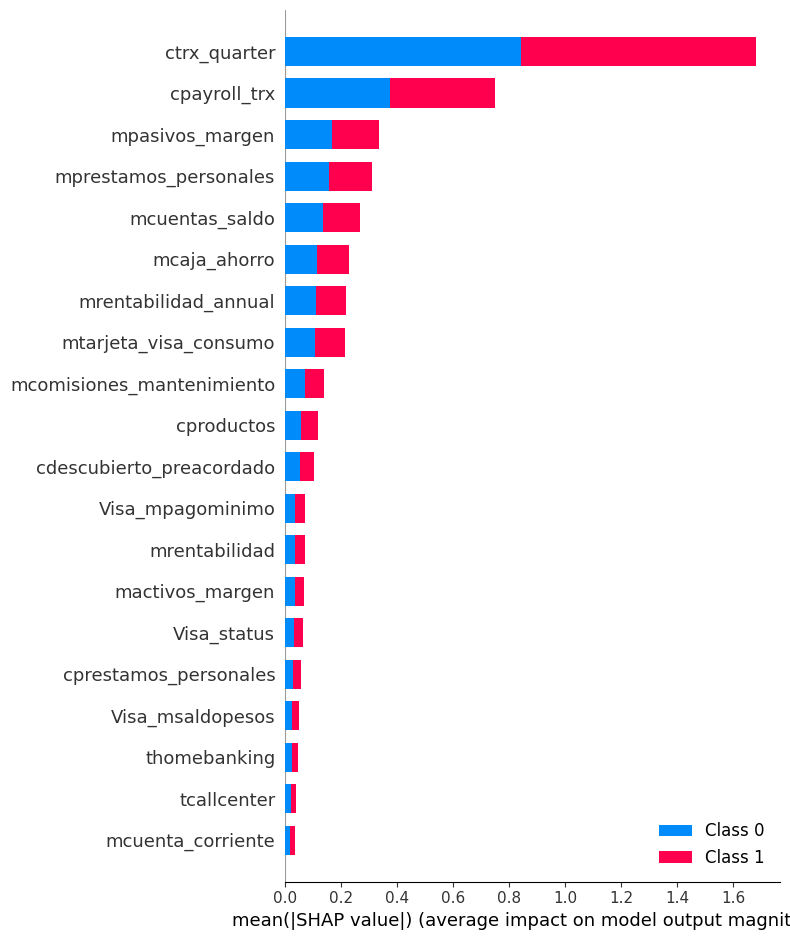

In [10]:
shap.summary_plot(shap_values, ds_bajas)


Para ver más opciones de visualización
https://www.youtube.com/watch?v=L8_sVRhBDLU&t=3s

## ¿Se podrá hacer una clusterización sobre los valores de shap?

Lo que estaríamos buscando es: "Juntar a todos los clientes que son afectamos por los mismos patrones del modelo, entendiendo que si les afecto el mismo patrón, sus SHAP van a ser similares." Presunción fuerte.
 
Como la cantidad de variables es muy alto, es conveniente hacer un embedding con **UMAP**. Por como es la estrutura de los **shap values** se pueden hacer sin mucho preprocesamiento. Usamos UMAP para estos embedding, https://www.youtube.com/watch?v=eN0wFzBA4Sc (triple BAM (?))

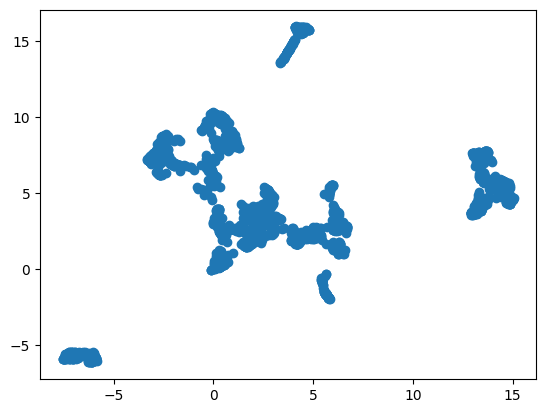

In [11]:
embedding_2d = UMAP(
  n_components=2, n_neighbors=40
).fit_transform(shap_values[0])
plt.scatter(embedding_2d[:,0], embedding_2d[:,1])

Vemos manchas separadas entre ellas, admiramos a UMAP. Hizo el trabajo sucio.

Algo importante cuando trabaja con modelos, es recordar que no siempre detectan con la misma "fuerza" todos los casos. Incluso nosotros solo terminamos mandando a Kaggle un subconjunto de casos. Si vemos el histograma de las probabilidades de salida

(array([464., 290., 203., 176., 156., 135., 105.,  71.,  70.,  73.,  47.,
         36.,  40.,  20.,  15.,  36.,  11.,  11.,   9.,  10.,   9.,   1.,
          9.,   1.,   5.,   0.,   2.,   1.,   2.,   4.]),
 array([0.00498115, 0.02289187, 0.04080259, 0.05871331, 0.07662403,
        0.09453475, 0.11244546, 0.13035618, 0.1482669 , 0.16617762,
        0.18408834, 0.20199906, 0.21990978, 0.2378205 , 0.25573122,
        0.27364193, 0.29155265, 0.30946337, 0.32737409, 0.34528481,
        0.36319553, 0.38110625, 0.39901697, 0.41692769, 0.4348384 ,
        0.45274912, 0.47065984, 0.48857056, 0.50648128, 0.524392  ,
        0.54230272]),
 <BarContainer object of 30 artists>)

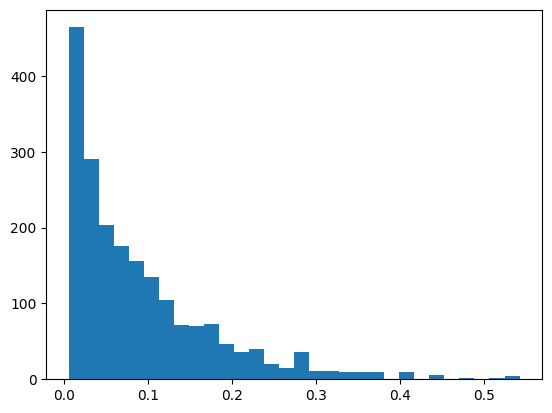

In [12]:
plt.hist(p_bajas,bins=30)

Vemos que hay en los 2000 y algo de casos, 500 que no estaríamos mandando. Veamos si hay alguna relación si cruzamos el embedding y su probabilidad

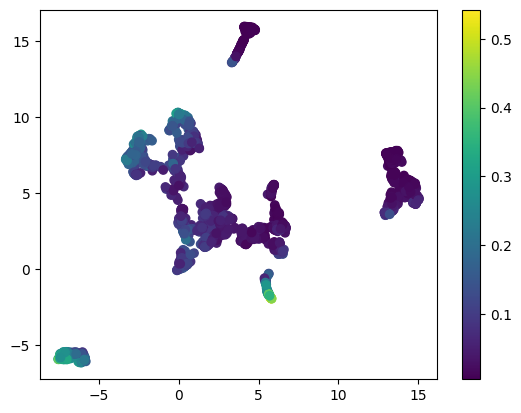

In [13]:
sc = plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=p_bajas)
plt.colorbar(sc)
plt.show()


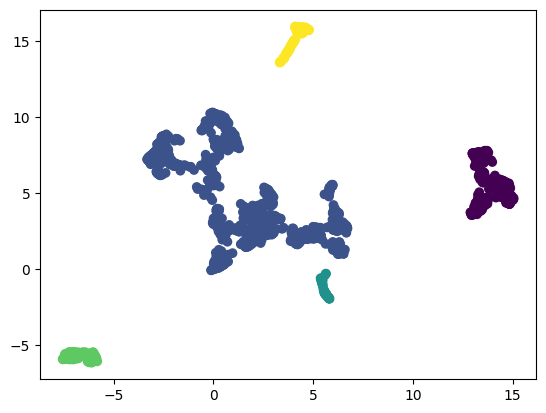

In [14]:

hdb = DBSCAN(eps=0.75) # juegue con los parámetros 
y = hdb.fit(embedding_2d)

plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=y.labels_)
plt.show()

Comparamos 2 clusters para ver si cambian sus variables importantes

In [15]:
shap_bajas[y.labels_ == 1].mean().sort_values(ascending=False)

chomebanking_transacciones            0.001926
ctarjeta_visa_debitos_automaticos     0.000344
ctransferencias_recibidas             0.000179
ccallcenter_transacciones             0.000173
mttarjeta_visa_debitos_automaticos    0.000103
                                        ...   
mcuentas_saldo                       -0.095076
mprestamos_personales                -0.133509
mpasivos_margen                      -0.151394
cpayroll_trx                         -0.336906
ctrx_quarter                         -0.965673
Length: 153, dtype: float64

In [16]:
shap_bajas[y.labels_ == 5].mean().sort_values(ascending=False)

foto_mes                  NaN
active_quarter            NaN
cliente_vip               NaN
internet                  NaN
cliente_edad              NaN
                           ..
Visa_fechaalta            NaN
Visa_mconsumototal        NaN
Visa_cconsumos            NaN
Visa_cadelantosefectivo   NaN
Visa_mpagominimo          NaN
Length: 153, dtype: float64

Y comparamos las distribuciones de las variables importantes con la de la población general, para entender que distingue a nuestro cluster.

divide by zero encountered in divide
invalid value encountered in divide


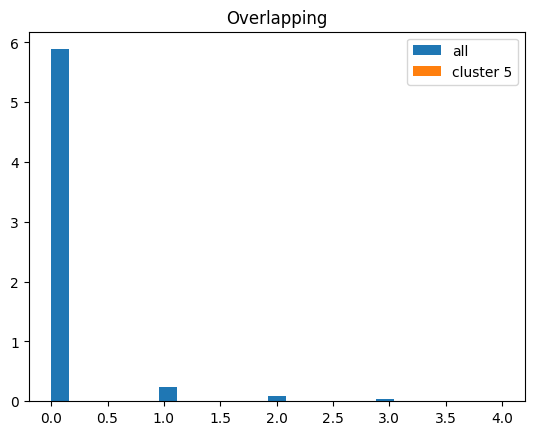

In [17]:
plt.hist(ds_bajas.loc[:]["cpayroll_trx"], label='all', density=True, bins=25)
plt.hist(ds_bajas.loc[y.labels_ == 5]["cpayroll_trx"], label='cluster 5', density=True, bins=25)

plt.legend(loc='upper right')
plt.title('Overlapping')
plt.show()

## Random Forest distance

Veremos otro forma de llegar clusters, pero usando las distancia del Random Forest como input del embedding. Para esto, es necesario primero hacer un RF. No lo haremos con todos los datos, mantendremos todos los **BAJAS** y tan solo algunos continua.

In [18]:
np.random.seed(17)
continua_sample = clase_train[clase_train == 0].sample(2000).index
bajas_1_2 = clase_train[clase_train == 1].index
rf_index = continua_sample.union(bajas_1_2)

In [19]:
XRF = ds_train.iloc[rf_index]
yRF = clase_train.iloc[rf_index]

In [20]:
def distanceMatrix(model, X):

    terminals = model.apply(X)
    nTrees = terminals.shape[1]

    a = terminals[:,0]
    proxMat = 1*np.equal.outer(a, a)

    for i in range(1, nTrees):
        a = terminals[:,i]
        proxMat += 1*np.equal.outer(a, a)

    proxMat = proxMat / nTrees

    return proxMat.max() - proxMat # transforma de una matriz de proximidad a una de distancia. 


imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
XRF_imp = imp_mean.fit_transform(XRF)

model = RandomForestClassifier(n_estimators=100, max_features=20, min_samples_leaf=400, )
model.fit(XRF_imp, yRF)
d = distanceMatrix(model, XRF_imp)

Y pasamos nuestra matriz de distancia al UMAP

using precomputed metric; inverse_transform will be unavailable


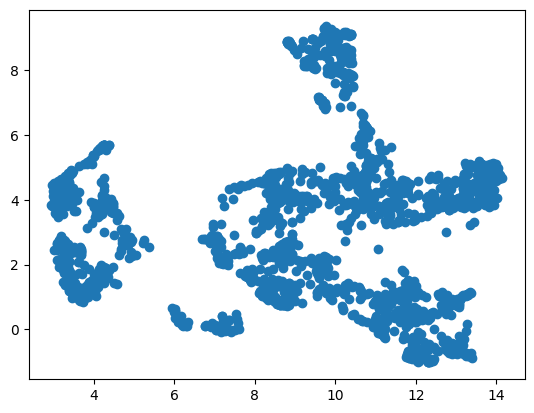

In [21]:
embedding_rf = UMAP( # Probar parámetros
  n_components=2,
  n_neighbors=50,
  metric="precomputed",
).fit_transform(d[yRF==1,][:,yRF==1]) # Solo los BAJAS paso... pero no sería interesante pasar todos?

plt.scatter(embedding_rf[:,0], embedding_rf[:,1])